In [1]:
import xgboost
import geopandas as gpd
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
features_race = ['white_alone_percent_cen', 'black_alone_percent_cen',
       'indigenous_alone_percent_cen', 'asian_alone_percent_cen',
       'pacific_islander_alone_percent_cen', 'other_alone_percent_cen',
       'multiracial_percent_cen']

features_transit_type = ['work_from_home_percent_cen',
       'automobile_to_work_percent_cen', 'public_transit_to_work_percent_cen',
       'taxi_to_work_percent_cen', 'motorcycle_to_work_percent_cen',
       'bike_to_work_percent_cen', 'walk_to_work_percent_cen',
       'other_to_work_percent_cen']

features_education = ['lt_9th_percent_cen',
       'no_diploma_percent_cen', 'high_school_percent_cen',
       'some_college_percent_cen', 'associates_percent_cen',
       'bachelors_percent_cen', 'graduate_degree_percent_cen']

features_employment = ['in_labor_force_20_64_percent_cen',
       'not_in_labor_force_20_64_percent_cen', 'unemployed_20_64_percent_cen',
       'below_poverty_line_percent_cen']

features = features_race + features_transit_type + features_education + features_employment + ['median_household_income_cen',
       'median_age_cen', 'polling_accessible', 'walking_transit_travel_time', 'driving_travel_time']

Here, we read in the training dataset.

In [3]:
data = gpd.read_file('../project_data/final_dataset/train_final_dataset_Chicago_no_outlier.geojson')
X= data[features]
y= data['VoterTurnoutPercentage'].values

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20)

# Baseline model

In [5]:
class baseline():
    def __init__(self):
        self.y_predict = None
    def fit(self, X_train,y_train):

        self.y_predict = np.mean(y_train)

    def predict(self, X_predict):
        return self.y_predict * np.ones(len(X_predict))
        

        
        
    

In [6]:

base = baseline()
base.fit(X_train, y_train)
y_predict_base = base.predict(X_val)
rmse_base = root_mean_squared_error(y_predict_base, y_val)
print(rmse_base)

10.230259404351026


So the number to beat is ~9-10% (after rerunning a few times)

# Linear regression

In [7]:
pipe_lr = Pipeline([('scale',StandardScaler()),('reg',LinearRegression())])
pipe_lr.fit(X_train,y_train)
y_predict_lr = pipe_lr.predict(X_val)
rmse_lr = root_mean_squared_error(y_predict_lr, y_val)
print(rmse_lr)

6.6008036359040405


# XGBoost

In [8]:
xgb_reg = xgboost.XGBRegressor(learning_rate=.05,
                                   max_depth=5,
                                   n_estimators=100,verbosity=3)
xgb_reg.fit(X_train, y_train,eval_set=[(X_val, y_val)])
y_predict_xgb = xgb_reg.predict(X_val)
rmse_xgb = root_mean_squared_error(y_predict_xgb, y_val)


[10:38:44] ======== Monitor (0): HostSketchContainer ========
[10:38:44] AllReduce: 0.000664s, 1 calls @ 664us

[10:38:44] MakeCuts: 0.000789s, 1 calls @ 789us

[10:38:44] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:9.93935
[1]	validation_0-rmse:9.65619
[2]	validation_0-rmse:9.40672
[3]	validation_0-rmse:9.17162
[4]	validation_0-rmse:8.96421
[5]	validation_0-rmse:8.75342
[6]	validation_0-rmse:8.55678
[7]	validation_0-rmse:8.38638
[8]	validation_0-rmse:8.21835
[9]	validation_0-rmse:8.05593
[10]	validation_0-rmse:7.92483
[11]	validation_0-rmse:7.80009
[12]	validation_0-rmse:7.67484
[13]	validation_0-rmse:7.57115
[14]	validation_0-rmse:7.47239
[15]	validation_0-rmse:7.37432
[16]	validation_0-rmse:7.29185
[17]	validation_0-rmse:7.20850
[18]	validation_0-rmse:7.13913
[19]	validation_0-rmse:7.06867
[20]	validation_0-rmse:7.01317
[21]	validation_0-rmse:6.93143
[22]	validation_0-rmse:6.88160
[23]	v

In [9]:
print(rmse_xgb)

6.237206633074741


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

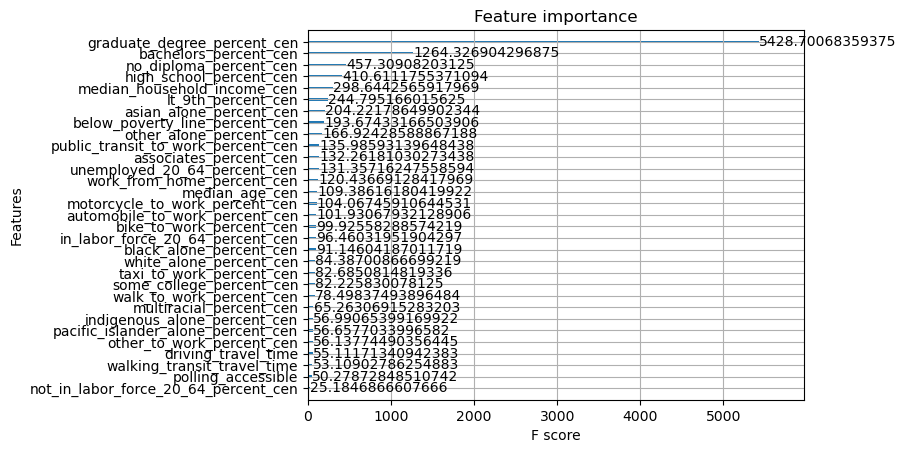

In [10]:
xgboost.plot_importance(xgb_reg, importance_type = 'gain')

NameError: name 'baseline_rmse' is not defined

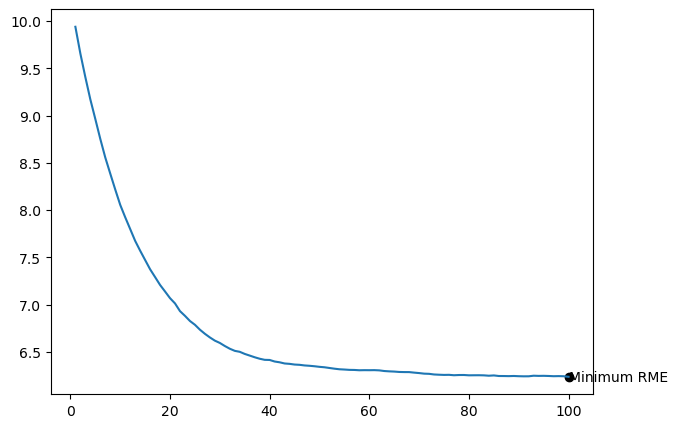

In [11]:
plt.figure(figsize=(7,5))

plt.plot(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1), 
         xgb_reg.evals_result()['validation_0']['rmse'], label = 'xgboost')
plt.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])]], 
            [np.min(xgb_reg.evals_result()['validation_0']['rmse'])], c='k')
plt.text(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])], 
         np.min(xgb_reg.evals_result()['validation_0']['rmse'])-.05, "Minimum RME", fontsize=10)

plt.hlines(baseline_rmse, 0,200, linestyle='--',color = 'k',label = 'baseline RMSE')

plt.title("Validation Error. Learning Rate = .05, max depth = 5", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xlim(0,100)
plt.ylim(4,12)
plt.legend()
plt.show()

In [ ]:
print('Baseline RMSE: {}'.format(rmse_base))
print('Linear Regression RMSE: {}'.format(rmse_lr))
print('XGBoost RMSE: {}'.format(rmse_xgb))

Baseline RMSE: 9.925005967818715
Linear Regression RMSE: 6.376145823180819
XGBoost RMSE: 6.156601463455593


# Feature selection using `statsmodels`

In [12]:
import statsmodels.api as sm
# import statsmodels.formula.api as smf

In [13]:
# First, scale the data.
scaler = StandardScaler()
X_train_scaled = gpd.GeoDataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

full_model = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()

def perform_f_test(X, full_features, reduced_features):
    X_train_full = X[full_features]
    X_train_reduced = X[reduced_features]

    # Create the models
    full_model = sm.OLS(y_train, sm.add_constant(X_train_full)).fit()
    reduced_model = sm.OLS(y_train, sm.add_constant(X_train_reduced)).fit()

    # Perform the F-test
    f_test = full_model.compare_f_test(reduced_model)

    # Print the results
    print("F-statistic:", f_test[0])
    print("p-value:", f_test[1])

### Travel time only
First, we use the reduced model with only the features `'walking_transit_travel_time'` and `'driving_travel_time'`.

In [14]:
perform_f_test(X_train_scaled, features, ['walking_transit_travel_time', 'driving_travel_time'])

F-statistic: 134.73652540091965
p-value: 0.0


Evidently, we should reject the reduced model.

### Education/Employment only

In [15]:
perform_f_test(X_train_scaled, features, features_education + features_employment)

F-statistic: 10.48485136919832
p-value: 1.669932577695357e-29


Evidently, we should reject the reduced model.

### Education/Employment + travel time only

In [16]:
perform_f_test(X_train_scaled, features, features_education + features_employment + ['walking_transit_travel_time', 'driving_travel_time'])

F-statistic: 10.91541963597535
p-value: 3.8546478251658393e-28


Evidently, we should reject the reduced model.

### Education/Employment + travel time only + median income

In [17]:
perform_f_test(X_train_scaled, features, features_education + features_employment 
               + ['walking_transit_travel_time', 'driving_travel_time', 'median_household_income_cen'])

F-statistic: 11.489509714119789
p-value: 2.3719441413616214e-28


### All but race

In [18]:
perform_f_test(X_train_scaled, features, features_transit_type + features_education + features_employment 
               + ['median_household_income_cen', 'median_age_cen', 'polling_accessible', 'walking_transit_travel_time', 
                  'driving_travel_time'])

F-statistic: 20.3433338413983
p-value: 7.678104316804026e-23
